In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import zipfile
from torch.utils.data.sampler import SubsetRandomSampler


%matplotlib inline

In [2]:
##Train
local_zip_train = '/kaggle/input/train.zip'
zip_ref = zipfile.ZipFile(local_zip_train, 'r')
zip_ref.extractall('/kaggle/working')
zip_ref.close()

##Test
local_zip_test = '/kaggle/input/test1.zip'
zip_ref = zipfile.ZipFile(local_zip_test, 'r')
zip_ref.extractall('/kaggle/working')
zip_ref.close()

In [3]:
train_dir = '../working/train'
test_dir = '../working/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [4]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train' or self.mode == 'val':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])

validation_split = .2
shuffle_dataset = True

dataset_size = len(catdogs)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainloader = DataLoader(catdogs, batch_size = 32,num_workers=4,sampler = train_sampler)
valloader = DataLoader(catdogs, batch_size = 32,num_workers=4,sampler = valid_sampler)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


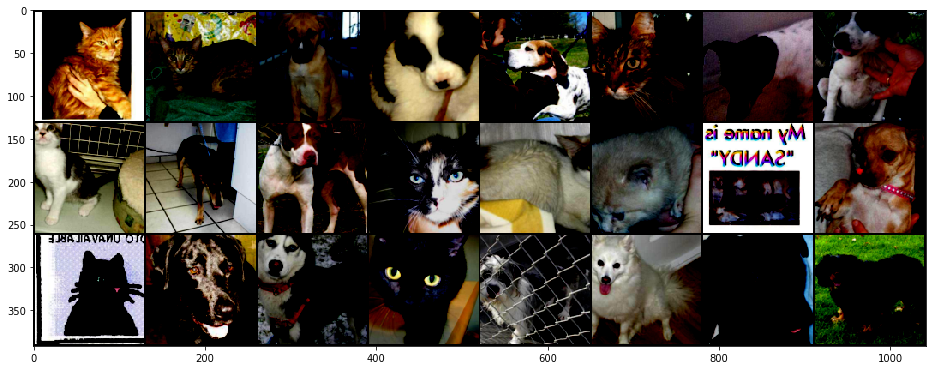

In [5]:
samples, labels = iter(trainloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [6]:
device = 'cuda'

In [7]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3,32,3,(1,1),padding=(1,1))
    self.conv2 = nn.Conv2d(32,32,3,(1,1),padding=(1,1))
    self.batch1 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(32,64,3,(1,1))
    self.conv4 = nn.Conv2d(64,64,2,(1,1),padding=(1,1))
    self.batch2 = nn.BatchNorm2d(64)
    
    self.conv5 = nn.Conv2d(64,128,3,(1,1),padding=(1,1))
    self.conv6 = nn.Conv2d(128,128,2,(2,2))
    self.batch3 = nn.BatchNorm2d(128)

    self.pool = nn.MaxPool2d(2,2)
    self.drop = nn.Dropout(0.2)

    self.fc1 = nn.Linear(128*7*7,1024)
    self.fc2 = nn.Linear(1024,512)
    self.fc3 = nn.Linear(512,256)
    self.fc4 = nn.Linear(256,128)
    self.fc5 = nn.Linear(128,64)
    self.fc6 = nn.Linear(64,32)
    self.fc7 = nn.Linear(32,2)

  def forward(self,x):
    x = F.relu(self.batch1(self.conv1(x)))
    x = F.relu(self.batch1(self.conv2(x)))
    x = self.pool(x)

    x = F.relu(self.batch2(self.conv3(x)))
    x = F.relu(self.batch2(self.conv4(x)))
    x = self.pool(x)
    
    x = F.relu(self.batch3(self.conv5(x)))
    x = F.relu(self.batch3(self.conv6(x)))
    x = self.pool(x)
    
    x = x.view(x.shape[0],128*7*7)

    x = F.relu(self.fc1(x))
    x = self.drop(x)
    x = F.relu(self.fc2(x))
    x = self.drop(x)
    x = F.relu(self.fc3(x))
    x = self.drop(x)
    x = F.relu(self.fc4(x))
    x = self.drop(x)
    x = F.relu(self.fc5(x))
    x = self.drop(x)
    x = F.relu(self.fc6(x))
    x = self.drop(x)
    x = self.fc7(x)

    return x

net = Net()
net = net.to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.002, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,
                                                       verbose=True)

In [9]:
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 32, shuffle=False, num_workers=4)

In [10]:
def model_eval(dataloader):
    total = 0
    correct = 0
    for data in dataloader:
      images, l = data
      images = images.to(device)
      l = l.to(device)

      out = net(images)
      max_val, preds = torch.max(out,dim=1)
      
      total += l.shape[0]                   
      correct += (preds == l).sum().item()  
      accuracy = (100 * correct)/total
    
    
    return accuracy 

In [11]:
for epoch in range(40):

  running_loss = 0.0
  train_loss = 0.0
  I = 0
  for i,data in enumerate(trainloader,0):

    inputs,labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    train_loss += loss.item()
    I += i

    if i % 100 == 99:    
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
      running_loss = 0.0
  
  train_loss = train_loss / I
  train_acc = model_eval(trainloader)
  val_acc = model_eval(valloader)
  scheduler.step(train_loss)
  
  print(train_loss)
  print("Training Accuracy:",train_acc,"Val Accuracy:",val_acc)
  print("")

[1,   100] loss: 0.695
[1,   200] loss: 0.690
[1,   300] loss: 0.676
[1,   400] loss: 0.679
[1,   500] loss: 0.662
[1,   600] loss: 0.651
0.0021620232664621795
Training Accuracy: 63.49 Val Accuracy: 63.92

[2,   100] loss: 0.648
[2,   200] loss: 0.625
[2,   300] loss: 0.618
[2,   400] loss: 0.612
[2,   500] loss: 0.589
[2,   600] loss: 0.591
0.00196336727585548
Training Accuracy: 71.38 Val Accuracy: 70.8

[3,   100] loss: 0.585
[3,   200] loss: 0.560
[3,   300] loss: 0.563
[3,   400] loss: 0.542
[3,   500] loss: 0.533
[3,   600] loss: 0.523
0.0017657246447526493
Training Accuracy: 74.045 Val Accuracy: 73.88

[4,   100] loss: 0.519
[4,   200] loss: 0.502
[4,   300] loss: 0.502
[4,   400] loss: 0.491
[4,   500] loss: 0.494
[4,   600] loss: 0.473
0.001591703625672903
Training Accuracy: 79.635 Val Accuracy: 80.04

[5,   100] loss: 0.463
[5,   200] loss: 0.481
[5,   300] loss: 0.469
[5,   400] loss: 0.456
[5,   500] loss: 0.450
[5,   600] loss: 0.457
0.0014809266439615152
Training Accuracy:

[40,   100] loss: 0.134
[40,   200] loss: 0.147
[40,   300] loss: 0.137
[40,   400] loss: 0.142
[40,   500] loss: 0.150
[40,   600] loss: 0.137
0.00045266008228063583
Training Accuracy: 94.655 Val Accuracy: 93.02

